# 深層学習day2

# 再帰型ニューラルネットワークの概念 

### RNNとは
* 時系列データに対応可能な、ニューラルネットワーク
___

### 時系列データ
* 時間的順序を追って一定間隔ごとに観察される
* 相互に統計的依存関係が認められる
* 例...音声データ、テキストデータ
___

### RNNの全体像
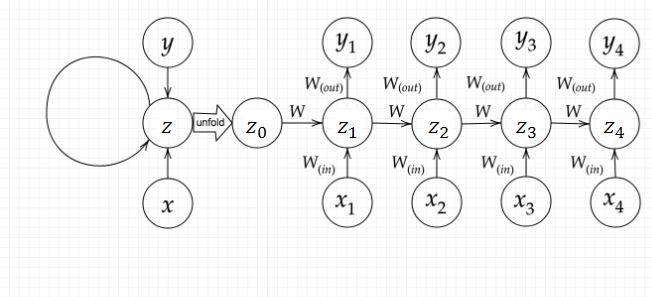
* 時刻tの中間層は、同じ時刻tの入力層からのインプットに加えて、前の時刻t-1の中間層からのインプットも受け取る→時刻間の影響を考慮したニューラルネットワークを作ることが可能
* 再帰的構造を持ったニューラルネットワークなので、Recursive Neural Networkと呼ぶ
* RNNでは、再帰的に出現する同一のネットワーク構造のことをセルと呼ぶ
___

### RNNの数式的記述
$$
u^t=W_{(in)}x^t+Wz^{t-1}+b\\
z^t=f(W_{(in)}x^t+Wz^{t-1}x^t+b)\\
v^t=W_{(out)}z^t+c\\
y^t=g(W_{(out)}z^t+c)
$$
___

### RNNのコード
```python
u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
z[:,t+1] = functions.sigmoid(u[:,t+1])

np.dot(z[:,t+1].reshape(1, -1), W_out)
y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
```
___

### 確認テスト①
#### Q.
RNNのネットワークには大きくわけて3つの重みがある。1つは入力から現在の中間層を定義する際にかけられる重み、1つは中間層から出力を定義する際にかけられる重みである。残り1つの重みについて説明せよ。
#### A.
前の時刻t-1の中間層からのインプットにかかる重み
___

### RNNの特徴
* 時系列モデルを扱うには、初期の状態と過去の時間t-1の状態を保持し、そこから次の時間でのtを再帰的に求める再帰構造が必要になる
___

### BPTT
* RNNにおいての誤差逆伝播手法
* 最後の時刻であるTから最初の0に向かって伝播していく
* すべての時系列データがなければ学習を行うことができないことが問題点
___

### 確認テスト②
#### Q.
$$
z=t^2\\t=x+y
$$
連鎖律の原理を使い、dz/dxを求めよ。
#### A.
$
\frac{\partial z}{\partial x}
=\frac{\partial z}{\partial t}\frac{\partial t}{\partial x}
=2t\\
=2(x+y)
$
___

### BPTTの数学的記述
$$
\frac{\partial E}{\partial W_{(in)}}=
\frac{\partial E}{\partial u^t}\left[\frac{\partial u^t}{\partial W_{(in)}}\right]^T=
\delta^t[x^t]^T\\
\frac{\partial E}{\partial W_{(out)}}=
\frac{\partial E}{\partial v^t}\left[\frac{\partial v^t}{\partial W_{(out)}}\right]^T=
\delta^{out,t} [z^t]^T\\
\frac{\partial E}{\partial W}=
\frac{\partial E}{\partial u^t}\left[\frac{\partial u^t}{\partial W}\right]^T= 
\delta^t[z^{t-1}]^T\\
\frac{\partial E}{\partial b}=
\frac{\partial E}{\partial u^t}\frac{\partial u^t}{\partial b}= 
\delta^t\\
\frac{\partial E}{\partial c}=
\frac{\partial E}{\partial v^t}\frac{\partial v^t}{\partial c}=
\delta^{out,t}
$$
___

### BPTTのコード
```python
np.dot(X.T, delta[:,t].reshape(1,-1))
np.dot(z[:,t+1].reshape(-1,1),delta_out[:,t].reshape(-1,1))
np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
```
___

### 確認テスト③
#### Q.
上図のy1をx・z0・z1・win・w・woutを用いて数式で表せ。※バイアスは任意の文字で定義せよ。※また中間層の出力にシグモイド関数g(x)を作用させよ。
#### A.
$$y_1=g\{W_{(out)}f\{W_{(in)}x_1+Wz_0+b\}+c\}$$
___

### ハンズオン

In [1]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

* 必要なライブラリのインポート

In [2]:
def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

In [62]:
binary_dim = 8
largest_number = pow(2, binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
print(binary)
input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1
weight_init_std = 1
learning_rate = 0.1
iters_num = 10000
plot_interval = 100

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]


* データの準備
* binary...0~256の2進数

In [63]:
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
print(W_in.shape)
print(W_out.shape)
print(W.shape)

(2, 16)
(16, 1)
(16, 16)


* 重みの初期化
* RNNなので、重みは3つ

In [64]:
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

* 勾配、中間値、出力値の初期化

In [65]:
for i in range(iters_num):
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int]
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int]
    d_int = a_int + b_int
    d_bin = binary[d_int]
    out_bin = np.zeros_like(d_bin)
    all_loss = 0    

    # RNN順伝播処理
    for t in range(binary_dim):
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        dd = np.array([d_bin[binary_dim - t - 1]])
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        loss = functions.mean_squared_error(dd, y[:,t])
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        all_loss += loss
        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # RNN逆伝播処理
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配の適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    
    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)

* 実際に学習
* 入力データ、教師データを定義
* 8桁の2進数を時系列データとみなし、加算を学習させる

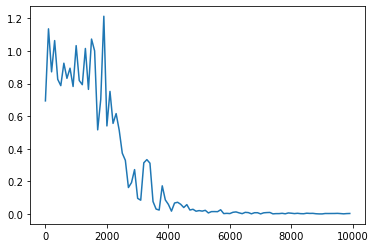

In [66]:
lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

* 誤差の描画
* 6000回目ほどで、誤差は0に収束している
___

# LSTM

### RNNの課題
* 時系列を遡れば遡るほど、勾配が消失していく→長い時系列の学習が困難
___